In [1]:
#importação das bibliotecas
import numpy as np
import pandas as pd
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, root_mean_squared_error

In [2]:
from utils.utils import *

In [3]:
df = pd.read_csv(r'data\opticalnetwork_dataset.csv')

In [4]:
for channel in string_features:
  for key in coef_mod.keys():
    df[f'coef_mod_{channel}_{key}'] = df[channel].apply(lambda x: coef_mod[key][x])
    

In [5]:
features = [feature for feature in df.columns if feature not in output_features+zero_features+string_features+const_input_features]

In [6]:
df_ann = df.copy()
X_features = df_ann[features].drop(columns=coef_mod0)
y_features = df_ann[output_features]
X_features.head(2)

,NumCh,NumSpans,DispPar,Spans_gamma,Spans_beta2,Spans_alpha,Spans_L,Spans_PdBmCh,coef_mod_Spans_ModFormatCh_1,coef_mod_Spans_ModFormatIntLeft_1,coef_mod_Spans_ModFormatIntRight_1
0,5,5,16.7,1.3,21.299985,0.2,80,-3.0,0.25,0.25,0.25
1,5,5,16.7,1.3,21.299985,0.2,80,-2.5,0.25,0.25,0.25


### OSNRdB NL

#### Simulação sem feature scaling

In [7]:
save_path_base = 'models\ANN/'

In [8]:
def build_model(xtrain_shape):
    model = tf.keras.models.Sequential(
      [layers.Dense(64, activation='relu', input_shape=[xtrain_shape[1]]),
       layers.Dense(64, activation='sigmoid'),
       layers.Dense(1)
      ]
    )
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

In [68]:
X_train_osnr, X_test_osnr, y_train_osnr, y_test_osnr = train_test_split(X_features, y_features, test_size=0.3)

#### Validação Cruzada

In [ ]:
ann_scores = cross_val_scores(build_model=build_model, X=X_features, y=y_features.OSNRdB_NL)

In [11]:
ann_scores

{'R²': [0.99874, 0.99763, 0.99635, 0.99179, 0.9991],
 'MAE': [0.07613, 0.09008, 0.10354, 0.17301, 0.06035],
 'MSE': [0.01936, 0.03697, 0.05697, 0.12453, 0.01354],
 'MEAN_MAE': 0.10062199999999999,
 'MEAN_MSE': 0.050274000000000006,
 'MEAN_R2': 0.9967219999999999}

In [471]:
results_osnr = {
      "R²": round(ann_scores['MEAN_R2'], 3),
      "MSE": round(ann_scores['MEAN_MSE'], 3),
      "MAE": round(ann_scores['MEAN_MAE'], 3)
  }
results_osnr


{'R²': 0.997, 'MSE': 0.05, 'MAE': 0.101}

In [69]:
model_osnr = build_model(X_train_osnr.shape)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

history = model_osnr.fit(
    X_train_osnr,
    y_train_osnr.OSNRdB_NL,
    epochs=1000,
    batch_size=64,
    validation_split=0.3,
    callbacks=[early_stop]
)

In [71]:
df_aux_osnr = X_test_osnr.copy()
df_aux_osnr['OSNRdB_NL_pred'] = model_osnr.predict(X_test_osnr)
df_aux_osnr['OSNRdB_NL'] = y_test_osnr.OSNRdB_NL
model_evaluation(df_aux_osnr['OSNRdB_NL_pred'], df_aux_osnr['OSNRdB_NL'], X_train_osnr)

474/474 [==============================] - 0s 613us/step


{'R²': 0.99984,
 'R²a': 0.99984,
 'MSE': 0.00241,
 'RMSE': 0.04908,
 'MAE': 0.03533}

In [472]:
def plot_scatter_comp(df, target, result_model_evaluation, figsize=(10,6), validation_mode = False):
  fig, ax = plt.subplots(figsize=figsize)
  label = {
    'OSNRdB_NL': r'$\mathrm{OSNR}_{\mathrm{NL}}$',
    'NLIN_Power': r'$\mathrm{NLIN}_{\mathrm{Power}}$'
  }[target]
  if validation_mode:
    title = f"Desempenho do modelo em relação\nao conjunto de validação:\nR² = {result_model_evaluation['R²']}, MAE = {result_model_evaluation['MAE']}\nMSE = {result_model_evaluation['MSE']}, RMSE = {round(result_model_evaluation['MSE']**0.5, 3)}"
  else:
    title= f"Estatísticas do modelo:\nR² = {result_model_evaluation['R²']}, MAE = {result_model_evaluation['MAE']}\nMSE = {result_model_evaluation['MSE']}, RMSE = {round(result_model_evaluation['MSE']**0.5, 3)}"

  target_pred = target + '_pred'
  ax.scatter(df[target], df[target_pred], label = 'Estimado')
  ax.plot(df[target], df[target], label=f'Curva ideal', color='r')
  ax.set(xlabel=f'{label} Real [dB]', ylabel=f'{label} Estimado [dB]')
  ax.legend(
    alignment='left', loc='upper left', title=title)
  ax.grid()
  fig.tight_layout()
  fig.show()

C:\Users\Victor\AppData\Local\Temp\ipykernel_20092\1934145402.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


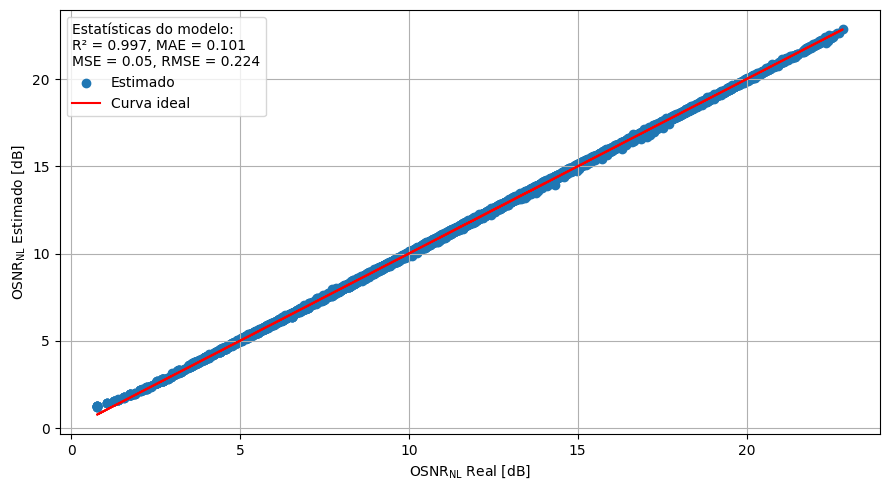

In [473]:
plot_scatter_comp(df_aux_osnr, 'OSNRdB_NL', results_osnr, figsize=(9,5))

coef_mod = 1/4, L = 100, NCh = 11, NSpam = 15

474/474 [==============================] - 0s 597us/step


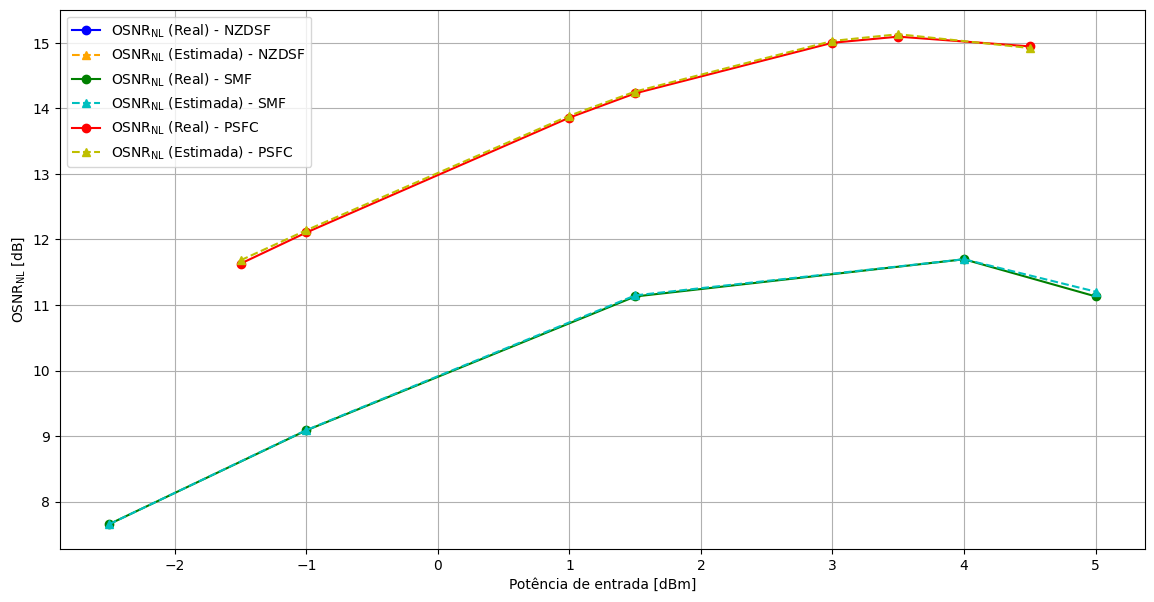

In [73]:
plot_all_fiber_pdBmCh(X_test_osnr, y_test_osnr, model_osnr, 'OSNRdB_NL', coef_mod=1/12)

In [205]:
df_val = pd.read_csv(r'data\Pchanel_variation.csv')
for channel in string_features:
  for key in coef_mod.keys():
    df_val[f'coef_mod_{channel}_{key}'] = df_val[channel].apply(lambda x: coef_mod[key][x])

5/5 [==============================] - 0s 750us/step


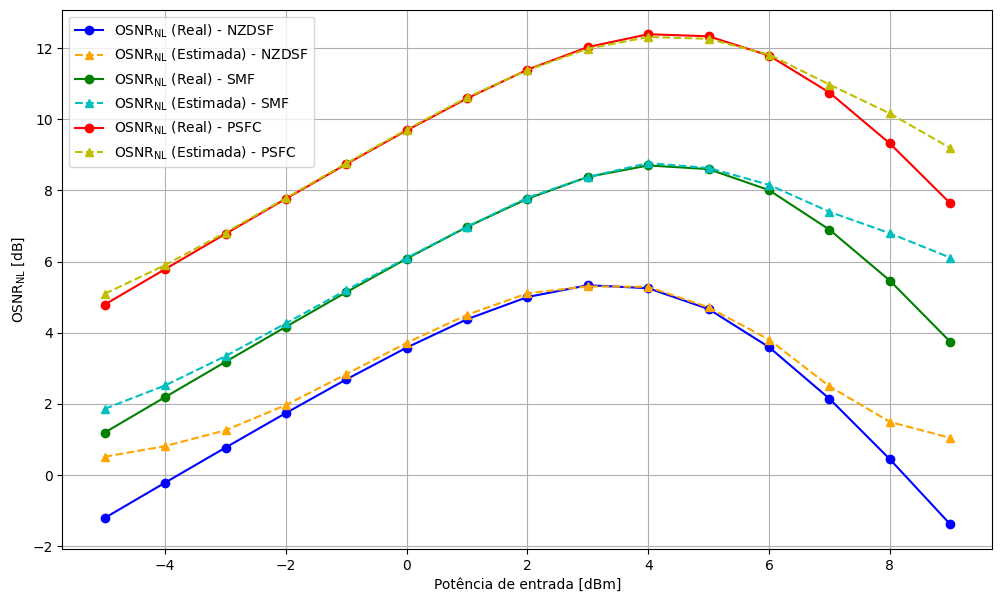

In [475]:
x_val = df_val[features].drop(columns=coef_mod0)
y_val = df_val[output_features]

plot_all_fiber_pdBmCh2(x_val, y_val, model_osnr, 'OSNRdB_NL', x_val, coef_mod=1/12, L=120, NSpam=15, NCh=15, figsize=(12, 7))

In [207]:
X_validation = df_val[features].drop(columns=coef_mod0)
y_validation = df_val[output_features]
y_validation2 = y_validation.copy()
y_validation2['OSNRdB_NL_pred'] = model_osnr.predict(X_validation)

5/5 [==============================] - 0s 1ms/step


In [208]:
df_to_plot_predict = y_validation.copy()
df_to_plot_predict[output_features + ['OSNRdB_NL_pred']] = y_validation2
results_osnr_Val = model_evaluation(df_to_plot_predict['OSNRdB_NL_pred'], df_to_plot_predict['OSNRdB_NL'], X_train_osnr)
results_osnr_Val

{'R²': 0.96497,
 'R²a': 0.96244,
 'MSE': 0.47658,
 'RMSE': 0.69035,
 'MAE': 0.37963}

In [439]:
result_val_osnr = {
    'R²': 0.965,
    'MSE': 0.477,
    'MAE': 0.38,
    'RMSE': 0.69
}

C:\Users\Victor\AppData\Local\Temp\ipykernel_20092\1934145402.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


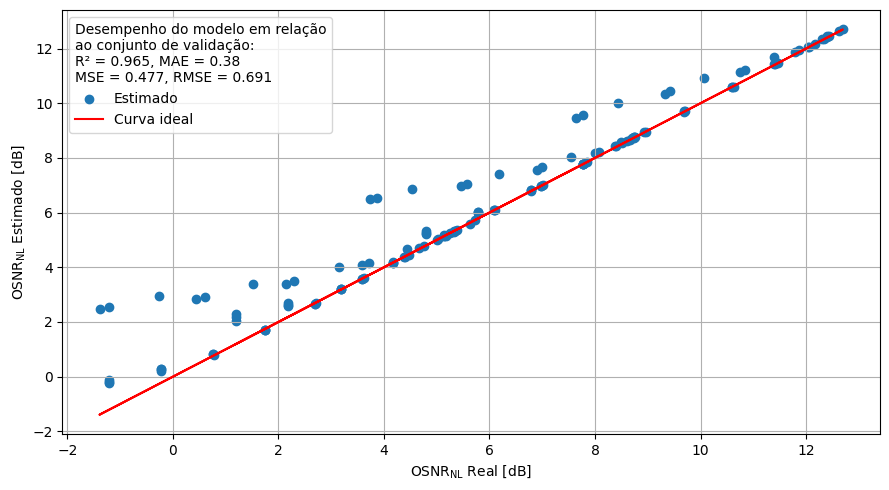

In [476]:
plot_scatter_comp(y_validation2, 'OSNRdB_NL', result_val_osnr, figsize=(9,5), validation_mode=True)

#### NLIN

In [ ]:
ann_scores_nlin = cross_val_scores(build_model=build_model, X=X_features, y=y_features.NLIN_Power)

In [149]:
ann_scores_nlin

{'R²': [0.99984, 0.99992, 0.99997, 0.99995, 0.99993],
 'MAE': [0.0794, 0.05549, 0.0376, 0.03704, 0.04903],
 'MSE': [0.01097, 0.00582, 0.00221, 0.00341, 0.00454],
 'MEAN_MAE': 0.051712,
 'MEAN_MSE': 0.00539,
 'MEAN_R2': 0.9999220000000001}

In [459]:
results_nlin = {
      "R²": round(ann_scores_nlin['MEAN_R2'], 3),
      "MSE": round(ann_scores_nlin['MEAN_MSE'], 3),
      "MAE": round(ann_scores_nlin['MEAN_MAE'], 3)
  }

results_nlin

{'R²': 1.0, 'MSE': 0.005, 'MAE': 0.052}

In [171]:
X_train_nlin, X_test_nlin, y_train_nlin, y_test_nlin = train_test_split(X_features, y_features, test_size=0.3)

In [172]:
model_nlin = build_model(X_train_nlin.shape)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

history_nlin = model_nlin.fit(
    X_train_nlin,
    y_train_nlin.NLIN_Power,
    epochs=1000,
    batch_size=64,
    validation_split=0.3,
    callbacks=[early_stop]
)

In [174]:
df_aux_nlin = X_test_nlin.copy()
df_aux_nlin['NLIN_Power_pred'] = model_nlin.predict(X_test_nlin)
df_aux_nlin['NLIN_Power'] = y_test_nlin.NLIN_Power
model_evaluation(df_aux_nlin['NLIN_Power_pred'], df_aux_nlin['NLIN_Power'], X_train_nlin)

474/474 [==============================] - 0s 598us/step


{'R²': 0.99996,
 'R²a': 0.99996,
 'MSE': 0.00247,
 'RMSE': 0.04967,
 'MAE': 0.04164}

C:\Users\Victor\AppData\Local\Temp\ipykernel_20092\1934145402.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


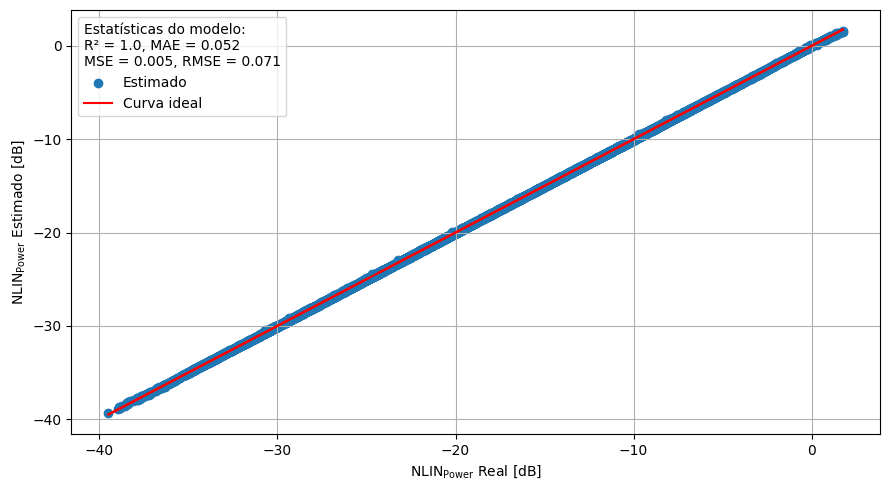

In [477]:
plot_scatter_comp(df_aux_nlin, 'NLIN_Power', results_nlin, figsize=(9,5))

L 110, NCh 11 Nspam 9 16qam

474/474 [==============================] - 0s 612us/step


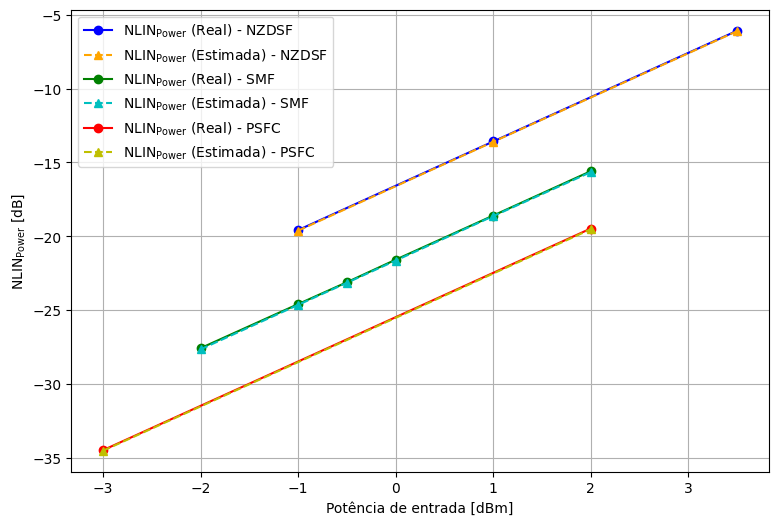

In [179]:
plot_all_fiber_pdBmCh(X_test_nlin, y_test_nlin, model_nlin, 'NLIN_Power', X_test_nlin, coef_mod=1/8, L=110, NSpam=9)

In [479]:
df_val = pd.read_csv(r'data\Pchanel_variation.csv')
for channel in string_features:
  for key in coef_mod.keys():
    df_val[f'coef_mod_{channel}_{key}'] = df_val[channel].apply(lambda x: coef_mod[key][x])

In [480]:
X_validation = df_val[features].drop(columns=coef_mod0)
y_validation = df_val[output_features]
y_validation2 = y_validation.copy()
y_validation2['NLIN_Power_pred'] = model_nlin.predict(X_validation)

5/5 [==============================] - 0s 1ms/step


In [481]:
df_to_plot_predict = y_validation.copy()
df_to_plot_predict[output_features + ['NLIN_Power_pred']] = y_validation2
results = model_evaluation(df_to_plot_predict['NLIN_Power_pred'], df_to_plot_predict['NLIN_Power'], X_train_nlin)

In [482]:
results

{'R²': 0.97205,
 'R²a': 0.97003,
 'MSE': 5.09015,
 'RMSE': 2.25614,
 'MAE': 1.01992}

In [483]:
result_val_nlin = {
    'R²': 0.972,
    'MSE': 5.09,
    'MAE': 1.02,
    'RMSE': 2.256
}

C:\Users\Victor\AppData\Local\Temp\ipykernel_20092\1934145402.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


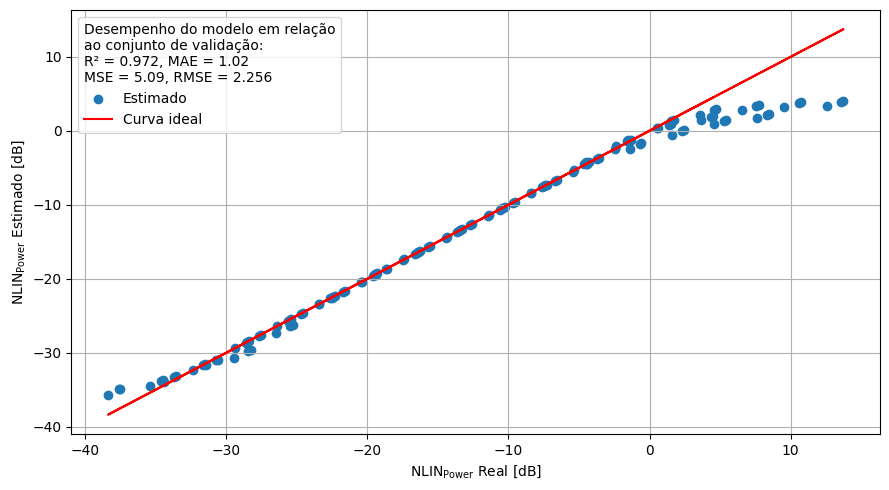

In [484]:
plot_scatter_comp(y_validation2, 'NLIN_Power', result_val_nlin, figsize=(9,5), validation_mode=True)

In [169]:
x_val = df_val[features].drop(columns=coef_mod0)
y_val = df_val[output_features]

5/5 [==============================] - 0s 1ms/step


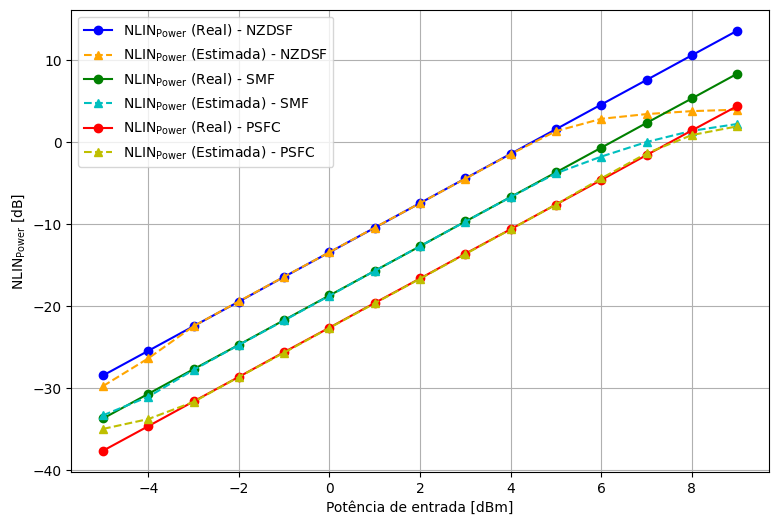

In [485]:
plot_all_fiber_pdBmCh(x_val, y_val, model_nlin, 'NLIN_Power', x_val, coef_mod=1/8, L=120, NSpam=15, NCh=15)

### Simulação com feature scaling

In [414]:
from sklearn.preprocessing import StandardScaler
scale_osnr = StandardScaler()

In [416]:
X_features_scaled = X_features.copy()
scale_osnr.fit(X_features_scaled)
X_features_scaled[X_features.columns] = scale_osnr.transform(X_features)

In [ ]:
ann_scores_osnr_scalrd = cross_val_scores(build_model=build_model, X=X_features_scaled, y=y_features.OSNRdB_NL)

In [418]:
results_osnr_scaled = {
      "R²": round(ann_scores_osnr_scalrd['MEAN_R2'], 3),
      "MSE": round(ann_scores_osnr_scalrd['MEAN_MSE'], 3),
      "MAE": round(ann_scores_osnr_scalrd['MEAN_MAE'], 3)
  }
results_osnr_scaled

{'R²': 0.996, 'MSE': 0.057, 'MAE': 0.108}

In [419]:
X_train_osnr_scaled, X_test_osnr_scaled, y_train_osnr_scaled, y_test_osnr_scaled = train_test_split(X_features_scaled, y_features, test_size=0.3)

In [420]:
model_osnr_scaled = build_model(X_train_osnr_scaled.shape)

In [ ]:
history_osnr_scalrd = model_osnr_scaled.fit(
    X_train_osnr_scaled,
    y_train_osnr_scaled.OSNRdB_NL,
    epochs=1000,
    batch_size=64,
    validation_split=0.3,
    callbacks=[early_stop]
)
df_aux_osnr_scaled = X_test_osnr_scaled.copy()
df_aux_osnr_scaled['OSNRdB_NL_pred'] = model_osnr_scaled.predict(X_test_osnr_scaled)
df_aux_osnr_scaled['OSNRdB_NL'] = y_test_osnr_scaled.OSNRdB_NL

In [422]:
model_evaluation(df_aux_osnr_scaled['OSNRdB_NL_pred'], df_aux_osnr_scaled['OSNRdB_NL'], X_train_osnr_scaled)

{'R²': 0.99996,
 'R²a': 0.99996,
 'MSE': 0.00055,
 'RMSE': 0.02354,
 'MAE': 0.01848}

C:\Users\Victor\AppData\Local\Temp\ipykernel_20092\1934145402.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


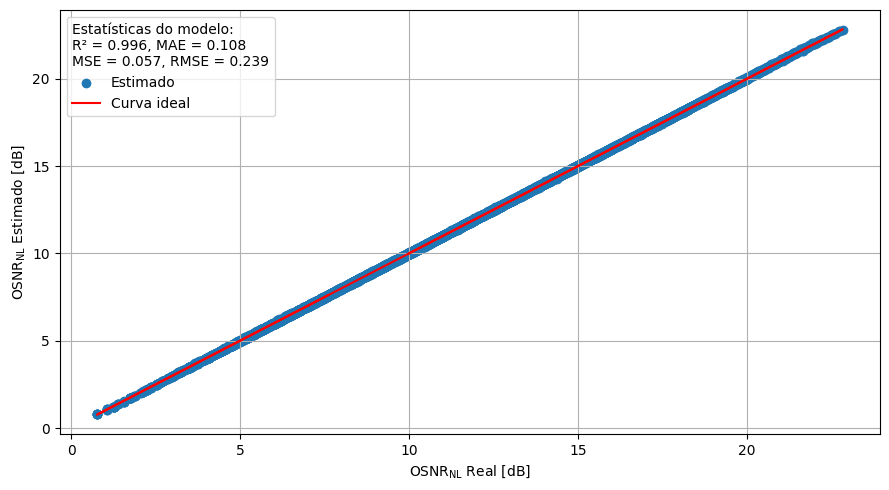

In [486]:
plot_scatter_comp(df_aux_osnr_scaled, 'OSNRdB_NL', results_osnr_scaled, figsize=(9,5))

In [230]:
def plot_all_fiber_pdBmCh2(df_x, df_y, model, target, df_not_scaled, coef_mod=1/4, L=100, NCh=11, NSpam=15, scaled=False, figsize=(9,6)):
    label = {
    'OSNRdB_NL': r'$\mathrm{OSNR}_{\mathrm{NL}}$',
    'NLIN_Power': r'$\mathrm{NLIN}_{\mathrm{Power}}$'
    }[target]
    color_per_fiber = {
    'NZDSF': ['b', 'orange'],
    'SMF': ['g','c'],
    'PSFC': ['r', 'y']
    }
    target_pred = target + '_pred'

    df_test = df_x.copy()
    y_test = df_y.copy()

    y_validation2 = y_test.copy()
    y_validation2[target_pred] = model.predict(df_test)
    if scaled: 
        df_to_plot_predict = df_not_scaled.loc[df_test.index]
    else:
        df_to_plot_predict = df_test.copy()

    df_to_plot_predict[output_features + [target_pred]] = y_validation2

    fig, ax = plt.subplots(figsize=figsize)
    for DispPar in [3.8, 16.7, 20.1]:   
        df_filtrado = df_to_plot_predict[df_to_plot_predict['DispPar'] == DispPar].copy()
        df_to_plot = filtrar(df_filtrado, **{
            'NumCh': NCh,
            'Spans_L': L,
            'NumSpans': NSpam,
            'coef_mod_Spans_ModFormatCh_1': coef_mod,
            'coef_mod_Spans_ModFormatIntLeft_1': coef_mod,
            'coef_mod_Spans_ModFormatIntRight_1': coef_mod,
            })
        df_to_plot=df_to_plot.sort_values(by='Spans_PdBmCh')
        ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot[target], label=f'{label} (Real) - {DisPar_to_Fiber[DispPar]}', marker='o', color=color_per_fiber[DisPar_to_Fiber[DispPar]][0])
        ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot[target_pred], linestyle='--', label=f'{label} (Estimada) - {DisPar_to_Fiber[DispPar]}', marker='^', color=color_per_fiber[DisPar_to_Fiber[DispPar]][1])

    ax.set(xlabel='Potência de entrada [dBm]', ylabel= f'{label} [dB]')
    ax.legend(loc='upper left')
    ax.grid()
    plt.show()

474/474 [==============================] - 0s 599us/step


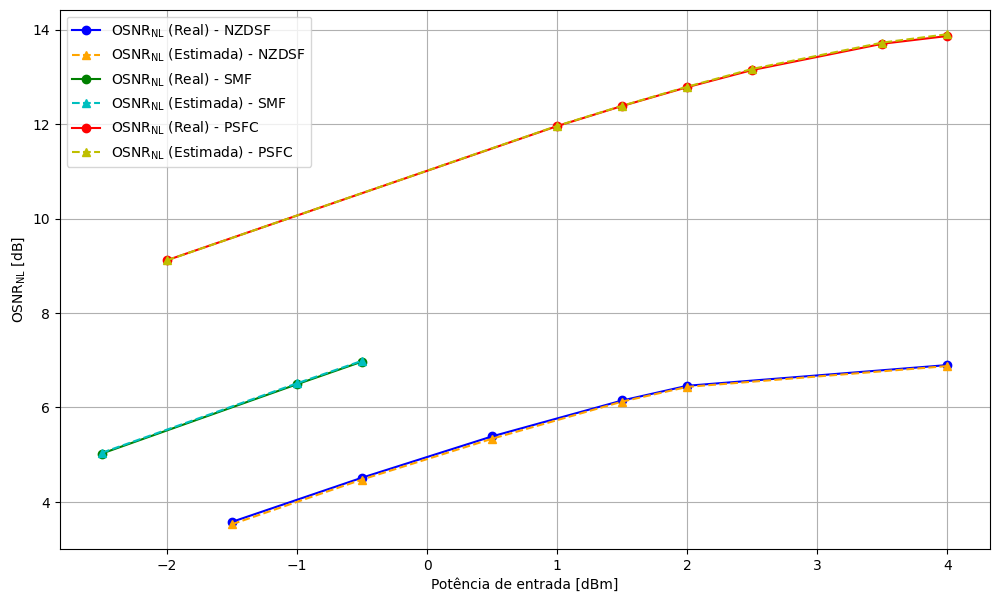

In [424]:
plot_all_fiber_pdBmCh2(X_test_osnr_scaled, y_test_osnr_scaled, model_osnr_scaled, 'OSNRdB_NL', X_features, coef_mod=1/12, L=120, NSpam=11, scaled=True, figsize=(12,7))

In [487]:
df_val = pd.read_csv(r'data\Pchanel_variation.csv')
for channel in string_features:
  for key in coef_mod.keys():
    df_val[f'coef_mod_{channel}_{key}'] = df_val[channel].apply(lambda x: coef_mod[key][x])


In [488]:
x_val = df_val[features].drop(columns=coef_mod0)
x_val_scaled = x_val.copy()

In [489]:
scale_osnr.mean_

array([ 10.00019807,  10.00015845,  13.53320789,   1.19999604,
        17.26090564,   0.19666653, 100.00079227,   0.99987126,
         0.15277888,   0.15277888,   0.15277888])

In [490]:
x_val_scaled[x_val.columns] = scale_osnr.transform(x_val_scaled)

In [491]:
scale_osnr.mean_

array([ 10.00019807,  10.00015845,  13.53320789,   1.19999604,
        17.26090564,   0.19666653, 100.00079227,   0.99987126,
         0.15277888,   0.15277888,   0.15277888])

In [492]:
x_val_scaled.head(2)

,NumCh,NumSpans,DispPar,Spans_gamma,Spans_beta2,Spans_alpha,Spans_L,Spans_PdBmCh,coef_mod_Spans_ModFormatCh_1,coef_mod_Spans_ModFormatIntLeft_1,coef_mod_Spans_ModFormatIntRight_1
0,1.463825,1.581108,0.451034,0.339691,0.451034,0.162225,1.414186,-2.449475,1.372774,1.372774,1.372774
1,1.463825,1.581108,0.451034,0.339691,0.451034,0.162225,1.414186,-2.041220,1.372774,1.372774,1.372774


In [493]:
y_val = df_val[output_features]

5/5 [==============================] - 0s 750us/step


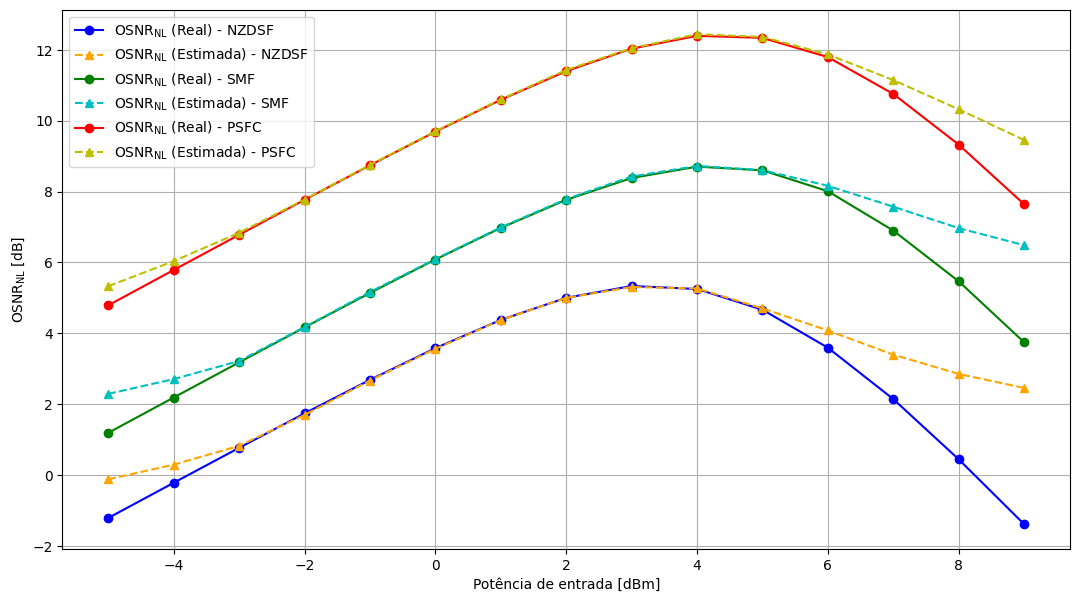

In [494]:
plot_all_fiber_pdBmCh2(x_val_scaled, y_val, model_osnr_scaled, 'OSNRdB_NL', x_val, coef_mod=1/12, L=120, NSpam=15, NCh=15, scaled=True, figsize=(13, 7))

In [495]:
X_validation = df_val[features].drop(columns=coef_mod0)
y_validation = df_val[output_features]

X_validation[X_validation.columns] = scale_osnr.transform(X_validation)

y_validation2 = y_validation.copy()
y_validation2['OSNRdB_NL_pred'] = model_osnr_scaled.predict(X_validation)

df_to_plot_predict = y_validation.copy()
df_to_plot_predict[output_features + ['OSNRdB_NL_pred']] = y_validation2
results_osnr_Val = model_evaluation(df_to_plot_predict['OSNRdB_NL_pred'], df_to_plot_predict['OSNRdB_NL'], X_train_osnr)
results_osnr_Val



5/5 [==============================] - 0s 756us/step


{'R²': 0.94226, 'R²a': 0.9381, 'MSE': 0.78544, 'RMSE': 0.88625, 'MAE': 0.42864}

In [496]:
result_val_osnr_scaled = {
    'R²': round(results_osnr_Val['R²'], 3),
    'MSE': round(results_osnr_Val['MSE'], 3),
    'MAE': round(results_osnr_Val['MAE'], 3),
    'RMSE': round(results_osnr_Val['RMSE'], 3)
}

C:\Users\Victor\AppData\Local\Temp\ipykernel_20092\1934145402.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


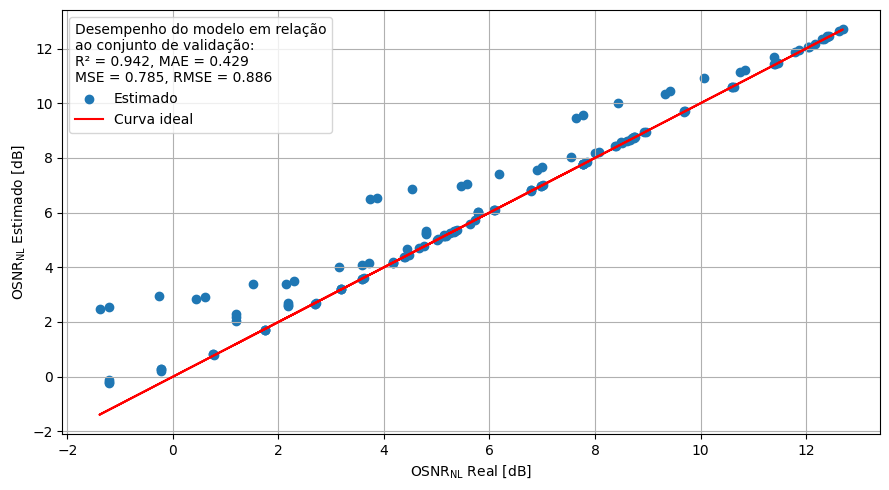

In [497]:
plot_scatter_comp(y_validation2, 'OSNRdB_NL', result_val_osnr_scaled, figsize=(9,5), validation_mode=True)

#### NLIN Power

In [394]:
from sklearn.preprocessing import StandardScaler
scale_nlin = StandardScaler()

In [395]:
X_features_scaled = X_features.copy()
scale_nlin.fit(X_features_scaled)
print()

In [396]:
X_features_scaled[X_features.columns] = scale_nlin.transform(X_features)
X_features_scaled.head()

,NumCh,NumSpans,DispPar,Spans_gamma,Spans_beta2,Spans_alpha,Spans_L,Spans_PdBmCh,coef_mod_Spans_ModFormatCh_1,coef_mod_Spans_ModFormatIntLeft_1,coef_mod_Spans_ModFormatIntRight_1
0,-1.463941,-1.581208,0.451034,0.339691,0.451034,0.162225,-1.414298,-1.632966,1.372774,1.372774,1.372774
1,-1.463941,-1.581208,0.451034,0.339691,0.451034,0.162225,-1.414298,-1.428838,1.372774,1.372774,1.372774
2,-1.463941,-1.581208,0.451034,0.339691,0.451034,0.162225,-1.414298,-1.224711,1.372774,1.372774,1.372774
3,-1.463941,-1.581208,0.451034,0.339691,0.451034,0.162225,-1.414298,-1.020584,1.372774,1.372774,1.372774
4,-1.463941,-1.581208,0.451034,0.339691,0.451034,0.162225,-1.414298,-0.816456,1.372774,1.372774,1.372774


In [390]:
ann_scores_nlin_scaled = cross_val_scores(build_model=build_model, X=X_features_scaled, y=y_features.NLIN_Power)

Epoch 1/1000
442/442 [==============================] - 1s 1ms/step - loss: 124.6800 - mae: 8.7374 - mse: 124.6800 - val_loss: 34.6881 - val_mae: 4.3643 - val_mse: 34.6881
Epoch 2/1000
442/442 [==============================] - 0s 1ms/step - loss: 16.3695 - mae: 2.5292 - mse: 16.3695 - val_loss: 7.6419 - val_mae: 1.8699 - val_mse: 7.6419
Epoch 3/1000
442/442 [==============================] - 1s 1ms/step - loss: 4.5452 - mae: 1.2254 - mse: 4.5452 - val_loss: 3.1078 - val_mae: 1.1923 - val_mse: 3.1078
Epoch 4/1000
442/442 [==============================] - 1s 1ms/step - loss: 1.7730 - mae: 0.7071 - mse: 1.7730 - val_loss: 1.3134 - val_mae: 0.7227 - val_mse: 1.3134
Epoch 5/1000
442/442 [==============================] - 1s 1ms/step - loss: 0.7953 - mae: 0.4451 - mse: 0.7953 - val_loss: 0.7114 - val_mae: 0.5522 - val_mse: 0.7114
Epoch 6/1000
442/442 [==============================] - 0s 1ms/step - loss: 0.4199 - mae: 0.3230 - mse: 0.4199 - val_loss: 0.4234 - val_mae: 0.4283 - val_mse: 0.4

In [504]:
results_nlin_scaled = {
      "R²": round(ann_scores_nlin_scaled['MEAN_R2'], 3),
      "MSE": round(ann_scores_nlin_scaled['MEAN_MSE'], 3),
      "MAE": round(ann_scores_nlin_scaled['MEAN_MAE'], 3)
  }
results_nlin_scaled

{'R²': 1.0, 'MSE': 0.001, 'MAE': 0.027}

In [397]:
X_train_nlin_scaled, X_test_nlin_scaled, y_train_nlin_scaled, y_test_nlin_scaled = train_test_split(X_features_scaled, y_features, test_size=0.3)

In [398]:
model_nlin_scaled = build_model(X_train_nlin_scaled.shape)

In [399]:
history_nlin_scaled = model_nlin_scaled.fit(
    X_train_nlin_scaled,
    y_train_nlin_scaled.NLIN_Power,
    epochs=1000,
    batch_size=64,
    validation_split=0.3,
    callbacks=[early_stop]
)

Epoch 1/1000
387/387 [==============================] - 1s 1ms/step - loss: 133.8456 - mae: 9.2023 - mse: 133.8456 - val_loss: 44.6249 - val_mae: 5.2797 - val_mse: 44.6249
Epoch 2/1000
387/387 [==============================] - 0s 1ms/step - loss: 21.1609 - mae: 3.1078 - mse: 21.1609 - val_loss: 8.4860 - val_mae: 1.8324 - val_mse: 8.4860
Epoch 3/1000
387/387 [==============================] - 0s 1ms/step - loss: 5.3345 - mae: 1.3818 - mse: 5.3345 - val_loss: 3.0902 - val_mae: 1.0277 - val_mse: 3.0902
Epoch 4/1000
387/387 [==============================] - 0s 1ms/step - loss: 2.1166 - mae: 0.8075 - mse: 2.1166 - val_loss: 1.3134 - val_mae: 0.6227 - val_mse: 1.3134
Epoch 5/1000
387/387 [==============================] - 0s 1ms/step - loss: 0.9640 - mae: 0.5053 - mse: 0.9640 - val_loss: 0.6354 - val_mae: 0.4104 - val_mse: 0.6354
Epoch 6/1000
387/387 [==============================] - 0s 1ms/step - loss: 0.5029 - mae: 0.3547 - mse: 0.5029 - val_loss: 0.3544 - val_mae: 0.3048 - val_mse: 0.3

In [498]:
df_aux_nlin_scaled = X_test_nlin_scaled.copy()
df_aux_nlin_scaled['NLIN_Power_pred'] = model_nlin_scaled.predict(X_test_nlin_scaled)
df_aux_nlin_scaled['NLIN_Power'] = y_test_nlin_scaled.NLIN_Power
model_evaluation(df_aux_nlin_scaled['NLIN_Power_pred'], df_aux_nlin_scaled['NLIN_Power'], X_train_nlin_scaled)

  1/474 [..............................] - ETA: 7s

474/474 [==============================] - 0s 853us/step


{'R²': 0.99998,
 'R²a': 0.99998,
 'MSE': 0.00144,
 'RMSE': 0.03794,
 'MAE': 0.03179}

C:\Users\Victor\AppData\Local\Temp\ipykernel_20092\1934145402.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


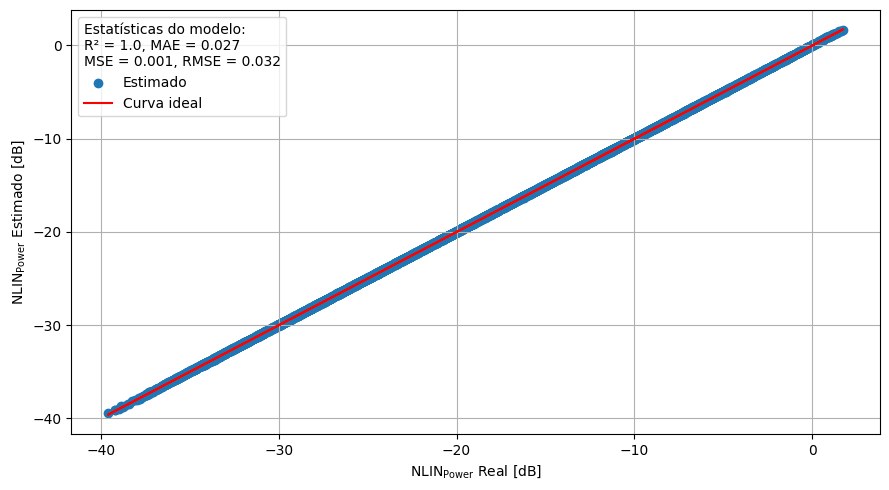

In [505]:
plot_scatter_comp(df_aux_nlin_scaled, 'NLIN_Power', results_nlin_scaled, figsize=(9,5))

474/474 [==============================] - 0s 619us/step


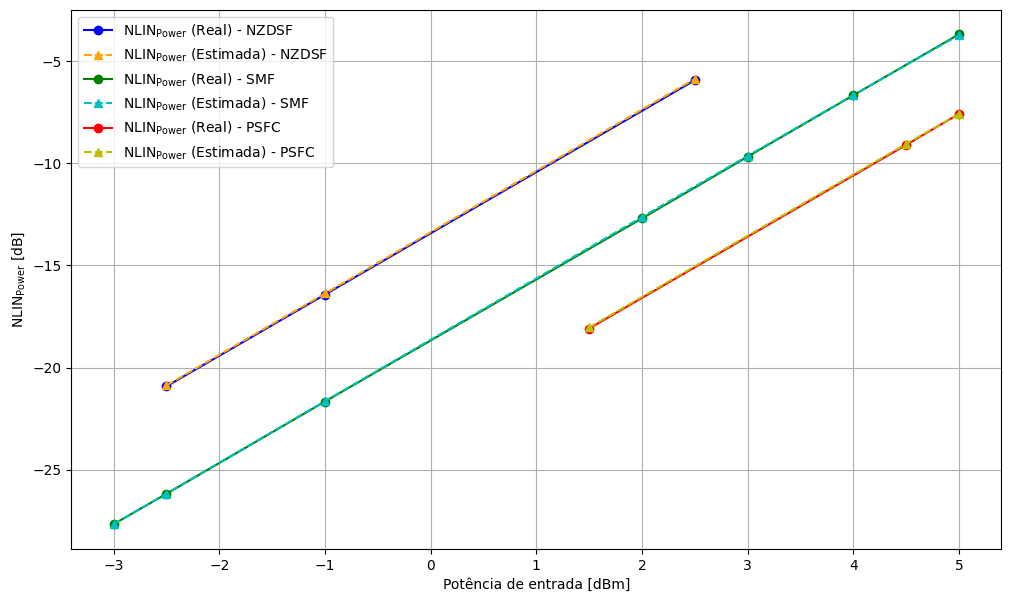

In [402]:
plot_all_fiber_pdBmCh2(X_test_nlin_scaled, y_test_nlin_scaled, model_nlin_scaled, 'NLIN_Power', X_features, coef_mod=1/12, L=100, NCh=13, NSpam=15, scaled=True, figsize=(12,7))

In [403]:
df_val = pd.read_csv(r'data\Pchanel_variation.csv')
for channel in string_features:
  for key in coef_mod.keys():
    df_val[f'coef_mod_{channel}_{key}'] = df_val[channel].apply(lambda x: coef_mod[key][x])

In [404]:
scale_nlin.mean_

array([ 10.00019807,  10.00015845,  13.53320789,   1.19999604,
        17.26090564,   0.19666653, 100.00079227,   0.99987126,
         0.15277888,   0.15277888,   0.15277888])

In [405]:
x_val_nlin = df_val[features].drop(columns=coef_mod0)
x_val_nlin_scaled = x_val.copy()

x_val_scaled[x_val_nlin.columns] = scale_nlin.transform(x_val_nlin_scaled)

y_val = df_val[output_features]

In [406]:
scale_nlin.mean_

array([ 10.00019807,  10.00015845,  13.53320789,   1.19999604,
        17.26090564,   0.19666653, 100.00079227,   0.99987126,
         0.15277888,   0.15277888,   0.15277888])

5/5 [==============================] - 0s 1ms/step


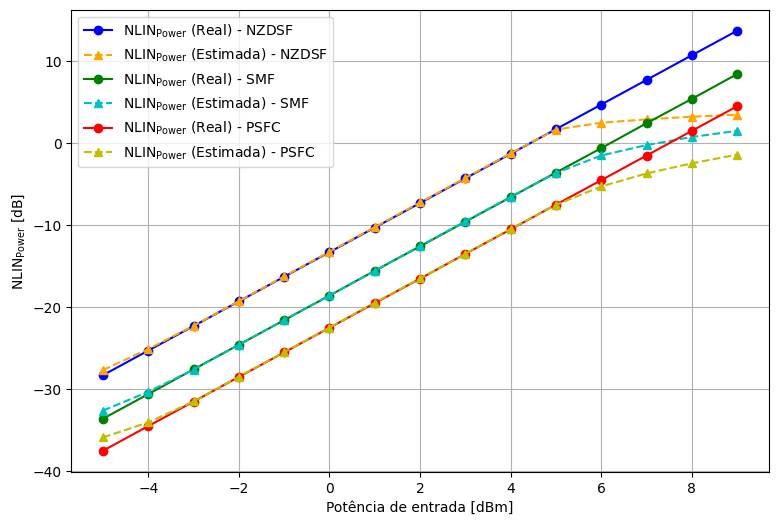

In [408]:
plot_all_fiber_pdBmCh2(x_val_scaled, y_val, model_nlin_scaled, 'NLIN_Power', x_val_nlin, coef_mod=1/12, L=120, NSpam=15, NCh=15, scaled=True)

In [500]:
X_validation = df_val[features].drop(columns=coef_mod0)
y_validation = df_val[output_features]

X_validation[X_validation.columns] = scale_nlin.transform(X_validation)

y_validation2 = y_validation.copy()
y_validation2['NLIN_Power_pred'] = model_nlin_scaled.predict(X_validation)

df_to_plot_predict = y_validation.copy()
df_to_plot_predict[output_features + ['NLIN_Power_pred']] = y_validation2
results_osnr_Val = model_evaluation(df_to_plot_predict['NLIN_Power_pred'], df_to_plot_predict['NLIN_Power'], X_train_osnr)
results_osnr_Val



5/5 [==============================] - 0s 1ms/step


{'R²': 0.96137,
 'R²a': 0.95858,
 'MSE': 7.03516,
 'RMSE': 2.65239,
 'MAE': 1.27059}

In [501]:
result_val_nlin_scaled = {
    'R²': 0.961,
    'MSE': 7.035,
    'MAE': 1.127,
    'RMSE': 2.652
}

C:\Users\Victor\AppData\Local\Temp\ipykernel_20092\1934145402.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


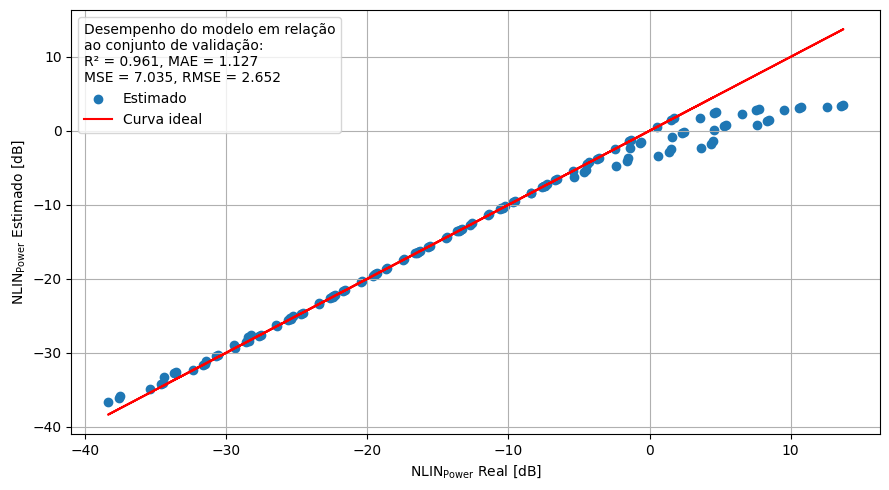

In [502]:
plot_scatter_comp(y_validation2, 'NLIN_Power', result_val_nlin_scaled, figsize=(9,5), validation_mode=True)